# Human exploration bias

This notebook explore the human bias in exploring large loss solution.

To do so, we calculate the following:
* the distribution of a random explorer testing a large loss (and three large losses)
* the distribution of humans testing large losses
* the change in likelihood in humans over the 3 / 6 trails


In [126]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
# add dqn sub folder to python path
import sys
sys.path.append('../algorithm')

In [128]:
import pandas as pd
import numpy as np
import os

import yaml
import json
import os


import torch as th
from dqn.environment_vect import Reward_Network
from dqn.config_type import Config

In [129]:
experiment_type = 'reward-network-iii-exp-v2'

moves_df = pd.read_csv(os.path.join('../data/exp_processed/moves.csv'))

networks_file = '../data/networks_solutions_models/solution_exp__valid_networks.json'

# Load the networks
with open(networks_file) as f:
    networks_exp = json.load(f)

config_file = '../algorithm/params/seed_0.yml'
with open(config_file) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
config = Config(**config)

In [130]:
moves_df.columns

Index(['session_id', 'session_name', 'replication_idx', 'condition',
       'generation', 'within_generation_idx', 'started_at', 'time_spend',
       'expired', 'replaced', 'ai_player', 'simulated_subject', 'advisor',
       'player_score', 'move_idx', 'source_num', 'target_num', 'reward',
       'level', 'correct_repeat', 'myopic', 'optimal', 'large_loss_taken',
       'trial_id', 'trial_type', 'network_id', 'solution_total_score'],
      dtype='object')

In [131]:
moves_df['session_trial_id'] = moves_df['session_id'].astype(str) + '_' + moves_df['trial_id'].astype(str)

session_trial_id = moves_df['session_trial_id'].unique()
session_trial_idx = {session_trial_id[i]: i for i in range(len(session_trial_id))}

filter_columns = [
    'session_trial_id', 'session_id', 'session_name', 'replication_idx', 'condition',
       'generation', 'within_generation_idx', 'ai_player', 'move_idx', 'source_num', 'target_num', 'reward',
       'network_id', 'trial_id', 'trial_type', 'level'
]
moves_df = moves_df[filter_columns]


In [132]:
human_moves = th.full((len(session_trial_id), 10), -1, dtype=th.int64)
network_ids = []

for _, row in moves_df.iterrows():
    idx = session_trial_idx[row['session_trial_id']]
    human_moves[idx, row['move_idx']] = row['target_num']
    if row['move_idx'] == 0:
        network_ids.append(row['network_id'])

In [133]:
networks_keyed = {network['network_id']: network for network in networks_exp}
networks_reorganized = [networks_keyed[network_id] for network_id in network_ids]

In [134]:
experiment_type = 'reward-network-iii-exp-v2'

DEVICE = th.device("cuda" if th.cuda.is_available() else "cpu")

env_random = Reward_Network(networks_reorganized, network_batch=None, config=config, device=DEVICE)

env_random.reset()
obs_random = env_random.observe()

random_rewards = []
random_moves = [env_random.starting_nodes]
random_levels = [th.ones_like(env_random.starting_nodes)]
for round_num in range(config.n_rounds):
    random_action = th.multinomial(obs_random["mask"].type(th.float), 1)[:, 0]
    obs_random, reward_random, level_random, is_done_random = env_random.step(random_action, normalize_reward=False)
    random_rewards.append(reward_random)
    random_moves.append(random_action)
    random_levels.append(level_random[:,0])
random_rewards = th.stack(random_rewards, dim=1)
random_moves = th.stack(random_moves, dim=1)
random_levels = th.stack(random_levels, dim=1)

environment_vect reward_norm_map tensor([ 0.0000, -1.0000, -0.7778, -0.3333,  0.1111,  1.0000])


/Users/brinkmann/repros/reward-network-iii/analysis/../algorithm/dqn/environment_vect.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.reward_map[prova_values] = torch.tensor(prova_keys, dtype=torch.long)


In [135]:
moves_random_df = moves_df.copy()
moves_random_df['random_counterfactual'] = True


for idx, row in moves_random_df.iterrows():
    session_idx = session_trial_idx[row['session_trial_id']]
    move_idx = row['move_idx']
    moves_random_df.at[idx, 'source_num'] = random_moves[session_idx, move_idx].item()
    moves_random_df.at[idx, 'target_num'] = random_moves[session_idx, move_idx+1].item()
    moves_random_df.at[idx, 'reward'] = random_rewards[session_idx, move_idx].item()
    moves_random_df.at[idx, 'level'] = random_levels[session_idx, move_idx].item() - 1

In [136]:
moves_df['random_counterfactual'] = False
joined_df = pd.concat([moves_df, moves_random_df])
joined_df = joined_df.sort_values(by=['session_trial_id', 'random_counterfactual', 'move_idx'])
joined_df = joined_df.reset_index(drop=True)

joined_df['is_loss'] = joined_df['reward'] < 0

In [137]:
joined_df['total_score'] = joined_df.groupby(['session_trial_id', 'random_counterfactual'])['reward'].transform('sum')
joined_df['n_loss'] = joined_df.groupby(['session_trial_id', 'random_counterfactual'])['is_loss'].transform('sum')
joined_df['max_level'] = joined_df.groupby(['session_trial_id', 'random_counterfactual'])['level'].transform('max')

In [138]:
# Ensure is_loss is binary (0/1)
is_loss = joined_df['is_loss'].astype(int)

# Identify where a new run starts (either is_loss == 0 or a break in sequence)
run_id = (
    (is_loss == 0) |
    (is_loss != is_loss.shift()) |
    (joined_df[['session_trial_id', 'random_counterfactual']]
     != joined_df[['session_trial_id', 'random_counterfactual']].shift()).any(axis=1)
).cumsum()

# Compute run lengths of consecutive losses
run_length = (
    joined_df
    .assign(run_id=run_id)
    .groupby(['session_trial_id', 'random_counterfactual', 'run_id'])['is_loss']
    .transform('sum')
)
joined_df['loss_consecutive'] = run_length
joined_df['max_loss_consecutive'] = joined_df.groupby(['session_trial_id', 'random_counterfactual'])['loss_consecutive'].transform('max')


In [139]:
agg_df = joined_df.groupby(['session_id', 'session_trial_id', 'random_counterfactual', 'trial_id', 'generation', 'ai_player', 'trial_type']).agg({
    'max_loss_consecutive': 'mean',
    'total_score': 'mean',
    'n_loss': 'mean',
    'max_level': 'mean'
}).reset_index()

agg_df['is_high_scoring'] = agg_df['total_score'] > 2000


In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def logit_clip(p, eps=1e-9):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))


def bootstrap_log_odds_ratio_by_category(
    df: pd.DataFrame,
    x: str,
    cond: str,
    *,
    group_cols=None,
    cluster_col: str | None = None,
    cond_ref=True,
    cond_target=False,
    n_boot: int = 2000,
    ci: float = 95,
    seed: int = 0,
    eps: float = 1e-9,
    dropna: bool = True,
    chunk_size: int = 4096,  # used for cluster bootstrap to limit peak memory
) -> pd.DataFrame:
    """
    Faster bootstrap one-vs-rest LOR per level of `x`.

    Key speedups:
      - Row bootstrap via multinomial draws over category counts (exact for categorical data).
      - Cluster bootstrap via resampling cluster-count vectors (no value concatenation).
      - Vectorized logit/LOR and percentile computation.
    """
    if group_cols is None:
        group_cols = []
    elif isinstance(group_cols, str):
        group_cols = [group_cols]

    cols = [x, cond] + group_cols + ([cluster_col] if cluster_col else [])
    d = df[cols].copy()

    if dropna:
        d = d.dropna(subset=[x, cond] + group_cols + ([cluster_col] if cluster_col else []))

    rng = np.random.default_rng(seed)
    alpha = (100 - ci) / 2

    def logit_clip(p: np.ndarray) -> np.ndarray:
        p = np.clip(p, eps, 1 - eps)
        return np.log(p / (1 - p))

    def lor_from_counts(ct: np.ndarray, cr: np.ndarray, nt: int, nr: int, a=0.5, b=0.5) -> np.ndarray:
        # Jeffreys-smoothed one-vs-rest probabilities per level
        if nt == 0 or nr == 0 or ct.size == 0:
            return np.full(ct.size, np.nan, dtype=float)
        pt = (ct + a) / (nt + a + b)
        pr = (cr + a) / (nr + a + b)
        return logit_clip(pt) - logit_clip(pr)

    out = []
    grouped = d.groupby(group_cols, dropna=False) if group_cols else [((), d)]

    for gkey, gdf in grouped:
        gdf_t = gdf.loc[gdf[cond] == cond_target]
        gdf_r = gdf.loc[gdf[cond] == cond_ref]

        # Levels defined within subgroup (across both conditions), as in your original code
        levels = np.array(sorted(pd.unique(gdf[x])), dtype=object)
        K = len(levels)

        # Diagnostics: observed counts per level in each condition
        ct_obs = gdf_t[x].value_counts().reindex(levels, fill_value=0).to_numpy(dtype=int)
        cr_obs = gdf_r[x].value_counts().reindex(levels, fill_value=0).to_numpy(dtype=int)
        nt = int(ct_obs.sum())
        nr = int(cr_obs.sum())

        lor_hat = lor_from_counts(ct_obs.astype(float), cr_obs.astype(float), nt, nr)

        # Bootstrap counts (vectorized)
        if K == 0 or nt == 0 or nr == 0:
            boot_lor = np.full((n_boot, K), np.nan, dtype=float)
        elif cluster_col is None:
            # --- FAST ROW BOOTSTRAP: multinomial over empirical probabilities ---
            pt = ct_obs / nt
            pr = cr_obs / nr

            # (n_boot, K) integer bootstrap counts
            Ct = rng.multinomial(nt, pt, size=n_boot)
            Cr = rng.multinomial(nr, pr, size=n_boot)

            # Vectorized LOR across bootstraps
            a = b = 0.5
            Pt = (Ct + a) / (nt + a + b)
            Pr = (Cr + a) / (nr + a + b)
            boot_lor = logit_clip(Pt) - logit_clip(Pr)

        else:
            # --- CLUSTER BOOTSTRAP: resample cluster count-vectors and sum ---
            # Build per-cluster count matrices for target and ref: shape (C, K)
            # Map x to categorical codes 0..K-1 for fast bincount
            code_map = {lvl: i for i, lvl in enumerate(levels)}

            def cluster_count_matrix(g: pd.DataFrame) -> tuple[np.ndarray, int]:
                if len(g) == 0:
                    return np.zeros((0, K), dtype=int), 0

                clus = g[cluster_col].dropna().unique()
                if len(clus) == 0:
                    return np.zeros((0, K), dtype=int), 0

                # For each cluster, compute counts over K levels
                mats = np.zeros((len(clus), K), dtype=int)
                for i, c in enumerate(clus):
                    vals = g.loc[g[cluster_col] == c, x].to_numpy(dtype=object)
                    codes = np.fromiter((code_map[v] for v in vals if v in code_map), dtype=int)
                    if codes.size:
                        mats[i] = np.bincount(codes, minlength=K)
                # Total rows in this condition (after dropping NaN clusters)
                n_rows = int(mats.sum())
                return mats, n_rows

            Mt, nt_eff = cluster_count_matrix(gdf_t)
            Mr, nr_eff = cluster_count_matrix(gdf_r)

            # If clusters missing in either condition, return NaNs like original “empty group” handling
            if Mt.shape[0] == 0 or Mr.shape[0] == 0 or nt_eff == 0 or nr_eff == 0:
                boot_lor = np.full((n_boot, K), np.nan, dtype=float)
                nt = int(gdf_t.shape[0])  # diagnostics remain comparable to your original
                nr = int(gdf_r.shape[0])
            else:
                # Note: in your original cluster bootstrap, you sample len(clusters) clusters with replacement.
                Ct_all = np.empty((n_boot, K), dtype=float)
                Cr_all = np.empty((n_boot, K), dtype=float)

                Ct_rows = Mt.shape[0]
                Cr_rows = Mr.shape[0]

                # Chunk to avoid (n_boot, C, K) blowups
                for start in range(0, n_boot, chunk_size):
                    end = min(n_boot, start + chunk_size)
                    B = end - start

                    it = rng.integers(0, Ct_rows, size=(B, Ct_rows))
                    ir = rng.integers(0, Cr_rows, size=(B, Cr_rows))

                    Ct = Mt[it].sum(axis=1)
                    Cr = Mr[ir].sum(axis=1)

                    Ct_all[start:end] = Ct
                    Cr_all[start:end] = Cr

                # Use Jeffreys smoothing with totals induced by bootstrap resampling
                # (these totals vary replicate-to-replicate under cluster resampling)
                a = b = 0.5
                nt_b = Ct_all.sum(axis=1)  # shape (n_boot,)
                nr_b = Cr_all.sum(axis=1)

                Pt = (Ct_all + a) / (nt_b[:, None] + a + b)
                Pr = (Cr_all + a) / (nr_b[:, None] + a + b)
                boot_lor = logit_clip(Pt) - logit_clip(Pr)

                # For reported diagnostics, keep original row counts as in your code
                nt = int(gdf_t.shape[0])
                nr = int(gdf_r.shape[0])

        lo = np.nanpercentile(boot_lor, alpha, axis=0)
        hi = np.nanpercentile(boot_lor, 100 - alpha, axis=0)

        # Group keys -> dict
        if group_cols:
            if not isinstance(gkey, tuple):
                gkey = (gkey,)
            gdict = dict(zip(group_cols, gkey))
        else:
            gdict = {}

        out.append(pd.DataFrame({
            **gdict,
            x: levels,
            "lor": lor_hat,
            "lor_lo": lo,
            "lor_hi": hi,
            "ci_width": hi - lo,
            "n_target": nt,
            "n_ref": nr,
            "count_target": ct_obs,
            "count_ref": cr_obs,
            "min_count": np.minimum(ct_obs, cr_obs),
        }))

    return pd.concat(out, ignore_index=True)

def dot_ci_plot(
    df, x, y, ylo, yhi, group=None,
    xlabel=None, ylabel=None, legend_title=None,
    spacing=0.4,
    point_size=8,
    ci_linewidth=2.5,
    zero_linewidth=1.5,
    spine_linewidth=1.5,
    tick_fontsize=12,
    label_fontsize=14,
    legend_fontsize=12
):
    fig, ax = plt.subplots()

    levels = sorted(df[x].unique())
    x_pos = {lvl: i for i, lvl in enumerate(levels)}

    if group is None:
        offsets = [0.0]
        groups = [None]
        base_color = "0.4"
    else:
        groups = sorted(df[group].unique())
        offsets = np.linspace(-spacing, spacing, len(groups))
        base_color = None

    for i, g in enumerate(groups):
        sub = df if g is None else df[df[group] == g]

        xs = np.array([x_pos[v] for v in sub[x]]) + offsets[i]
        ys = sub[y].values
        los = sub[ylo].values
        his = sub[yhi].values

        if group is None:
            pts = ax.plot(xs, ys, "o", color=base_color, markersize=point_size)
            color = base_color
        else:
            pts = ax.plot(xs, ys, "o", label=str(g), markersize=point_size)
            color = pts[0].get_color()

        ax.vlines(xs, los, his, color=color, linewidth=ci_linewidth)

    ax.set_xticks(range(len(levels)))
    ax.set_xticklabels(levels, fontsize=tick_fontsize)
    ax.set_xlabel(xlabel or x, fontsize=label_fontsize)
    ax.set_ylabel(ylabel or y, fontsize=label_fontsize)

    ax.axhline(0, linestyle="--", linewidth=zero_linewidth, color="black")

    ax.spines["left"].set_visible(True)
    ax.spines["left"].set_linewidth(spine_linewidth)
    for spine in ["top", "right", "bottom"]:
        ax.spines[spine].set_visible(False)

    ax.tick_params(axis="y", labelsize=tick_fontsize)

    if group is not None:
        ax.legend(
            title=legend_title or group,
            bbox_to_anchor=(1.02, 0.5),
            loc="center left",
            fontsize=legend_fontsize,
            title_fontsize=legend_fontsize
        )

    return fig



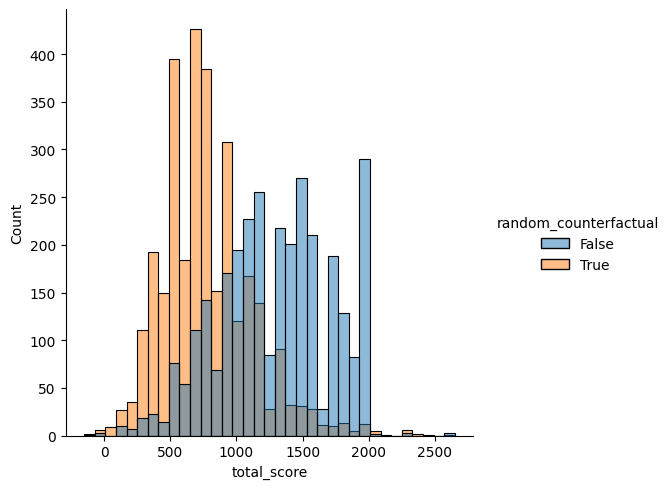

In [141]:
not_ai = ~agg_df['ai_player']
i_trail = agg_df['trial_type'] == 'individual'

df_i = agg_df[i_trail & not_ai]

sns.displot(data=df_i, x='total_score', hue='random_counterfactual', kind='hist')


<Axes: xlabel='random_counterfactual', ylabel='is_high_scoring'>

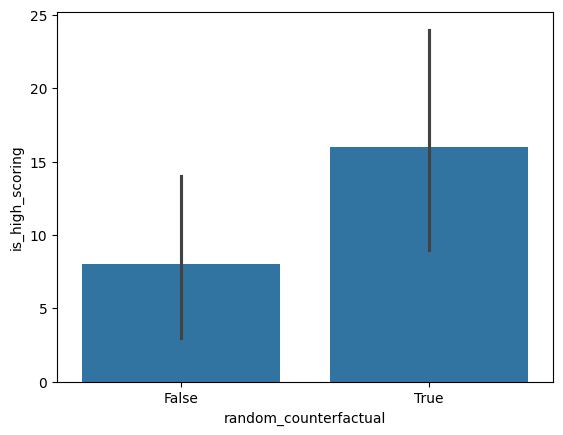

In [142]:
not_ai = ~agg_df['ai_player']
i_trail = agg_df['trial_type'] == 'individual'

df_i = agg_df[i_trail & not_ai]

sns.barplot(data=df_i, y='is_high_scoring', x='random_counterfactual', estimator=np.sum)

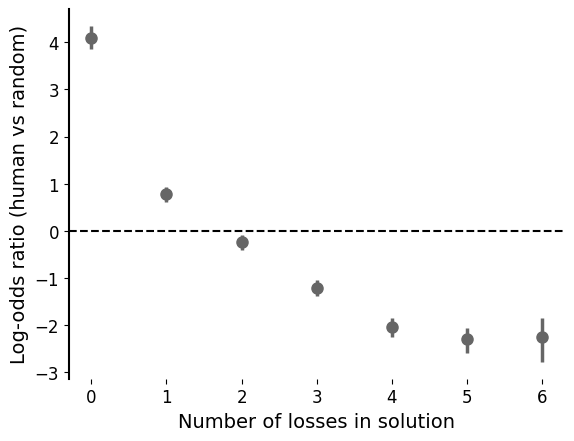

In [165]:
not_ai = ~agg_df['ai_player']
i_trail = agg_df['trial_type'] == 'individual'

df_i = agg_df[i_trail & not_ai]

lor_df = bootstrap_log_odds_ratio_by_category(df_i, n_boot=2000, ci=95, seed=42, x='n_loss', cond='random_counterfactual', cluster_col='session_id')

lor_df = lor_df[lor_df['n_loss'] <= 6]
lor_df['n_loss'] = lor_df['n_loss'].astype(int)

fig = dot_ci_plot(lor_df, x='n_loss', xlabel="Number of losses in solution", ylabel="Log-odds ratio (human vs random)", y='lor', ylo='lor_lo', yhi='lor_hi')

fig.savefig('plots/bias/lor_n_loss.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
fig.savefig('plots/bias/lor_n_loss.pdf', bbox_inches='tight', pad_inches=0.1)

In [146]:
lor_df

,n_loss,lor,lor_lo,lor_hi,ci_width,n_target,n_ref,count_target,count_ref,min_count
0,0,4.087475,3.848638,4.348804,0.500167,3085,3085,1785,69,69
1,1,0.771360,0.603805,0.938667,0.334862,3085,3085,449,225,225
2,2,-0.240704,-0.402051,-0.086419,0.315632,3085,3085,355,438,355
3,3,-1.209468,-1.372621,-1.050995,0.321626,3085,3085,260,728,260
4,4,-2.042053,-2.248655,-1.857747,0.390908,3085,3085,142,838,142
5,5,-2.290179,-2.589320,-2.052556,0.536764,3085,3085,72,592,72
6,6,-2.252207,-2.781697,-1.843447,0.938250,3085,3085,20,184,20


<Axes: xlabel='max_level', ylabel='count'>

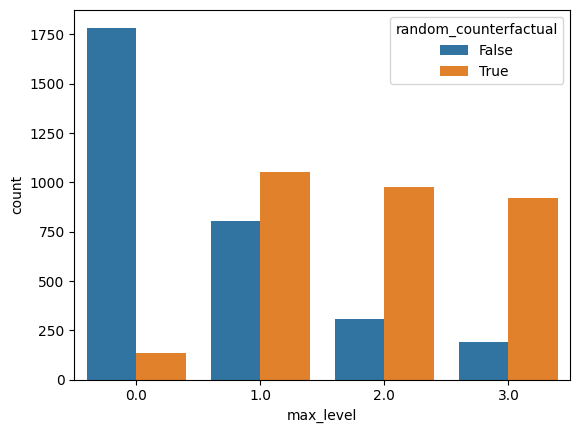

In [160]:
not_ai = ~agg_df['ai_player']
i_trail = agg_df['trial_type'] == 'individual'

df_i = agg_df[i_trail & not_ai]

sns.countplot(df_i, x='max_level', hue='random_counterfactual')

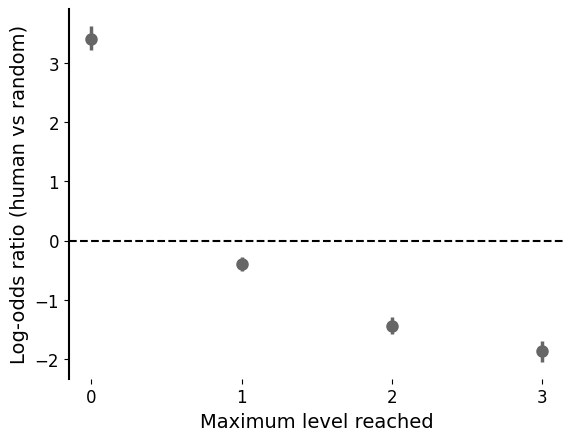

In [161]:
not_ai = ~agg_df['ai_player']
i_trail = agg_df['trial_type'] == 'individual'

df_i = agg_df[i_trail & not_ai]

lor_df = bootstrap_log_odds_ratio_by_category(df_i, n_boot=2000, ci=95, seed=42, x='max_level', cond='random_counterfactual', cluster_col='session_id')

lor_df['max_level'] = lor_df['max_level'].astype(int)

fig = dot_ci_plot(
    lor_df, x='max_level', xlabel="Maximum level reached", ylabel="Log-odds ratio (human vs random)", 
    y='lor', ylo='lor_lo', yhi='lor_hi',
    )

fig.savefig('plots/bias/lor_max_level.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
fig.savefig('plots/bias/lor_max_level.pdf', bbox_inches='tight', pad_inches=0.1)



In [149]:
lor_df

,max_level,lor,lor_lo,lor_hi,ci_width,n_target,n_ref,count_target,count_ref,min_count
0,0,3.405454,3.212099,3.620569,0.408469,3085,3085,1785,134,134
1,1,-0.388584,-0.507312,-0.268999,0.238313,3085,3085,802,1053,802
2,2,-1.434577,-1.582878,-1.287361,0.295517,3085,3085,306,976,306
3,3,-1.857731,-2.047145,-1.699153,0.347993,3085,3085,192,922,192


In [150]:
lor_df

,max_level,lor,lor_lo,lor_hi,ci_width,n_target,n_ref,count_target,count_ref,min_count
0,0,3.405454,3.212099,3.620569,0.408469,3085,3085,1785,134,134
1,1,-0.388584,-0.507312,-0.268999,0.238313,3085,3085,802,1053,802
2,2,-1.434577,-1.582878,-1.287361,0.295517,3085,3085,306,976,306
3,3,-1.857731,-2.047145,-1.699153,0.347993,3085,3085,192,922,192


In [151]:
print("df_i rows:", len(df_i))
print(df_i["random_counterfactual"].value_counts(dropna=False))
print("n_loss missing:", df_i["n_loss"].isna().mean())


df_i rows: 6170
random_counterfactual
False    3085
True     3085
Name: count, dtype: int64
n_loss missing: 0.0


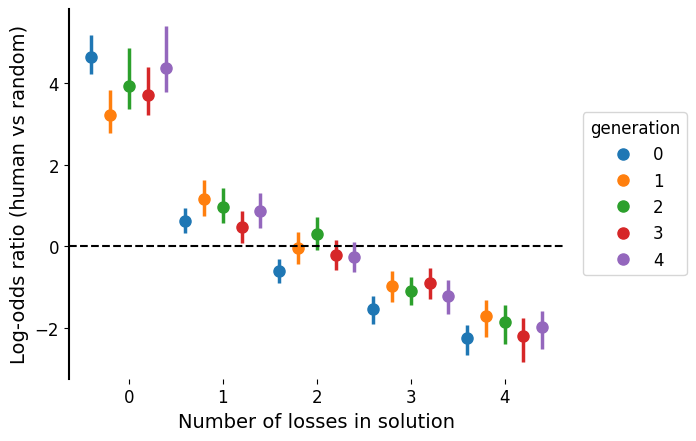

In [163]:
not_ai = ~agg_df['ai_player']
i_trail = agg_df['trial_type'] == 'individual'
df_i = agg_df[i_trail & not_ai]

lor_df = bootstrap_log_odds_ratio_by_category(
    df_i,
    n_boot=2000,
    ci=95,
    seed=42,
    x='n_loss',
    cond='random_counterfactual',
    group_cols=['generation'],
    cond_ref=True,
    cond_target=False,
    cluster_col='session_id'
)

lor_df['n_loss'] = lor_df['n_loss'].astype(int)
lor_df = lor_df[lor_df['n_loss'] <= 4]

fig = dot_ci_plot(lor_df, x='n_loss', xlabel="Number of losses in solution", ylabel="Log-odds ratio (human vs random)", y='lor', ylo='lor_lo', yhi='lor_hi', group='generation')

fig.savefig('plots/bias/lor_n_loss_by_generation.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
fig.savefig('plots/bias/lor_n_loss_by_generation.pdf', bbox_inches='tight', pad_inches=0.1)


In [156]:
lor_df

,generation,n_loss,lor,lor_lo,lor_hi,ci_width,n_target,n_ref,count_target,count_ref,min_count
0,0,0,4.635882,4.235556,5.180774,0.945218,1166,1166,781,22,22
1,0,1,0.616575,0.340256,0.932109,0.591853,1166,1166,142,81,81
2,0,2,-0.596466,-0.904778,-0.311736,0.593042,1166,1166,100,170,100
3,0,3,-1.535015,-1.895494,-1.219448,0.676046,1166,1166,73,277,73
4,0,4,-2.252291,-2.651265,-1.921374,0.729891,1166,1166,44,319,44
8,1,0,3.213974,2.773200,3.832624,1.059424,480,480,246,19,19
9,1,1,1.152911,0.747876,1.629344,0.881468,480,480,77,27,27
10,1,2,-0.035350,-0.430244,0.351310,0.781554,480,480,64,66,64
11,1,3,-0.971327,-1.366841,-0.613813,0.753029,480,480,53,119,53
12,1,4,-1.711830,-2.218114,-1.307863,0.910251,480,480,31,134,31


/var/folders/wh/f6_1ytx113vbrnfq49_n24pr0000gp/T/ipykernel_52882/165391937.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_i['trial'] = df_i['trial_id'].rank(method='dense').astype(int)


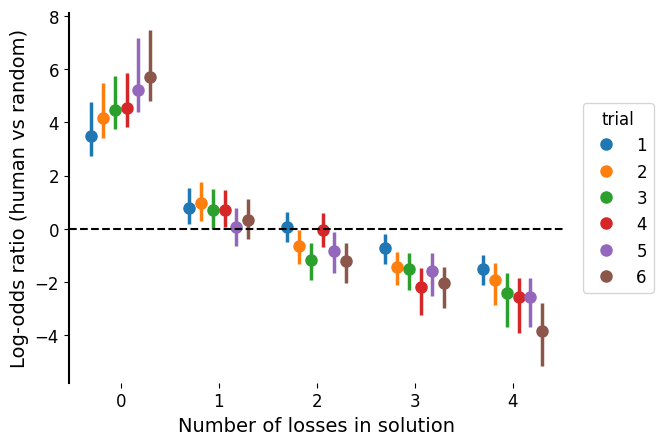

In [164]:
not_ai = ~agg_df['ai_player']
i_trail = agg_df['trial_type'] == 'individual'
gen_0 = agg_df['generation'] == 0
df_i = agg_df[i_trail & not_ai & gen_0]

df_i['trial'] = df_i['trial_id'].rank(method='dense').astype(int)

lor_df = bootstrap_log_odds_ratio_by_category(
    df_i,
    n_boot=4000,
    ci=95,
    seed=42,
    x='n_loss',
    cond='random_counterfactual',
    group_cols=['trial'],
    cond_ref=True,
    cond_target=False,
)

lor_df['n_loss'] = lor_df['n_loss'].astype(int)
lor_df = lor_df[lor_df['n_loss'] <= 4]

fig = dot_ci_plot(
    lor_df, x='n_loss', xlabel="Number of losses in solution", 
    ylabel="Log-odds ratio (human vs random)", y='lor', ylo='lor_lo', yhi='lor_hi', group='trial', spacing=0.3)

fig.savefig('plots/bias/lor_n_loss_in_gen0.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
fig.savefig('plots/bias/lor_n_loss_in_gen0.pdf', bbox_inches='tight', pad_inches=0.1)

In [158]:
lor_df

,trial,n_loss,lor,lor_lo,lor_hi,ci_width,n_target,n_ref,count_target,count_ref,min_count
0,1,0,3.477311,2.738025,4.757158,2.019133,194,194,84,4,4
1,1,1,0.797001,0.160182,1.517752,1.357570,194,194,29,14,14
2,1,2,0.082216,-0.491849,0.619797,1.111646,194,194,29,27,27
3,1,3,-0.728875,-1.321131,-0.197359,1.123771,194,194,22,41,22
4,1,4,-1.515594,-2.112392,-0.988035,1.124356,194,194,19,65,19
7,2,0,4.177326,3.425037,5.492463,2.067426,192,192,117,4,4
8,2,1,0.964123,0.293430,1.759986,1.466556,192,192,27,11,11
9,2,2,-0.657538,-1.330580,-0.041749,1.288831,192,192,16,29,16
10,2,3,-1.427413,-2.116504,-0.879468,1.237037,192,192,15,51,15
11,2,4,-1.923554,-2.852937,-1.275904,1.577032,192,192,9,50,9
